# Facebook conversation analysis, conversation clustering and personnal text generator

The goal of this project was to analyse my facebook conversation and try to extract some information from it.

This notebook is splited in different parts :

- Non text indicators : In this first part i try to analyse quickly the number of calls, pictures, links shared with my correspondants (it is not really interesting in my case but it can be useful for someone)
- Tf-Idf wordclouds for each conversations : I tried to design personalized  word clouds  for each conversations
- Conversation embedding and clustering : Based on the text of each conversation, I use clustering technics to create groups and see if it feets with my different affinities
- Personnal word embedding (with W2V)
- Text generation (language model) based on my conversations (using an RNN/LSTM algorithm) 

(I also  tried to do a chatbot but it failed).

It is not completly finished for the moment but it gives an idea of what it is possible to do with this data.

For reasons of confidentiality each conversor names has been anonymized and the data is not available. I encourage you to download this Notebook and try it with your own conversations. The wordclouds and the clustering was pretty accurate for me and can be interesting to gain some insights about my conversations.

This notebook is adapted for french conversations. If you want to use it for any other language you might make some changes. 

## To download your own facebook conversation data 

Here is the tuto I followed to download my Facebook conversation : https://www.zapptales.com/en/download-facebook-messenger-chat-history-how-to/
(I picked JSON format instead of HTML one).


Then I went to the archive in messages -> inbox and pick the conversations (json files) I wanted to analyse, rename them, and put them in a file appart named "conversations".

## Non text indicators

### Data preparation for the overall analysis 


For this part we just want to get the all to get the key indcators for of our conversations. I am not interested in the text for itself and thus we will not preprerocess it.

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import json
from ftfy import fix_text
import datetime
import unicodedata
np.random.seed(133)
%matplotlib inline

In [2]:
#Get all the JSON files name in the conversations folder

path = os.getcwd() + '\conversations'
convs = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
overall_data = pd.DataFrame()


for file in convs:
    with open(os.path.join(path, file)) as f:
        data = json.load(f)
    # Creates an identifier (title) for all the message of the conversation  if you want a  non anonimized  use name = data["title"] 
    name = file.replace(".json","")
    a = data["messages"]
    
    #Stores messages in a temporary dataframe
    df = pd.DataFrame(a)
    #Fixes the encoding problems
    df['sender_name'] =df['sender_name'].apply(fix_text)
    df['content'] =df['content'].astype(str).apply(fix_text)
    #Creates a name for the conversation
    df['conv_name'] = name
    overall_data = pd.concat([overall_data,df],axis=0)

In [3]:
# Dataframe head 
overall_data[overall_data.sender_name == 'Loïc'].drop('ip',axis = 1).sample(frac=1).iloc[0:3]

,sender_name,timestamp_ms,content,type,reactions,photos,sticker,gifs,conv_name,call_duration,missed,share,files,videos,audio_files,users
7387,Loïc,1566386484911,?,Generic,NaN,NaN,NaN,NaN,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1556,Loïc,1435403754669,Coucou !,Generic,NaN,NaN,NaN,NaN,BM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1475,Loïc,1565300275719,Enfin on était sur la bonne route en tt cas,Generic,NaN,NaN,NaN,NaN,LP,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Convert ms into seconds
overall_data["timestamp"] = overall_data["timestamp_ms"]/1000.0
#Convert timestamp into DateTime
overall_data["datetime"] = overall_data["timestamp"].apply(datetime.datetime.fromtimestamp)
#Number of words of each messages
overall_data["nb_words"] = overall_data["content"].str.split().str.len()
#Days, Month, Years
overall_data['day_of_week'] = overall_data['datetime'].dt.day_name()
overall_data['month'] = overall_data['datetime'].dt.month_name()
overall_data['date'] = overall_data['datetime'].dt.date

#### Messages according to time

In [5]:
day = overall_data.groupby('day_of_week').agg({'content' : "count"}).reset_index()
month = overall_data.groupby('month').agg({'content' : "count"}).reset_index()
year = overall_data.groupby('date').agg({'content' : "count"}).reset_index()




Text(0.5, 1.0, 'Messages sent by days')

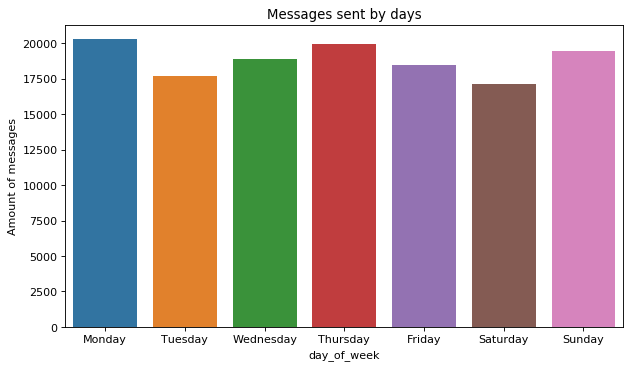

In [6]:
fig=plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = pd.CategoricalDtype(categories=cats, ordered=True)
day['day_of_week'] = day['day_of_week'].astype(cat_type)
ax = sns.barplot(x="day_of_week", y="content", data=day)
plt.ylabel("Amount of messages")

plt.title("Messages sent by days")

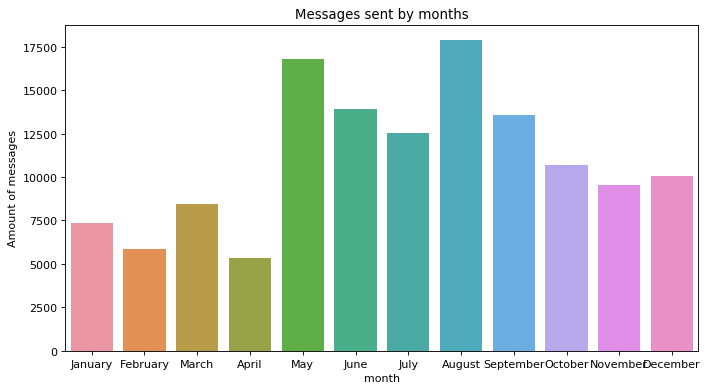

In [7]:
fig=plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')

cats = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']
cat_type = pd.CategoricalDtype(categories=cats, ordered=True)
month['month'] = month['month'].astype(cat_type)
ax = sns.barplot(x="month", y="content", data=month)
plt.title("Messages sent by months")
plt.ylabel("Amount of messages")

plt.tight_layout()

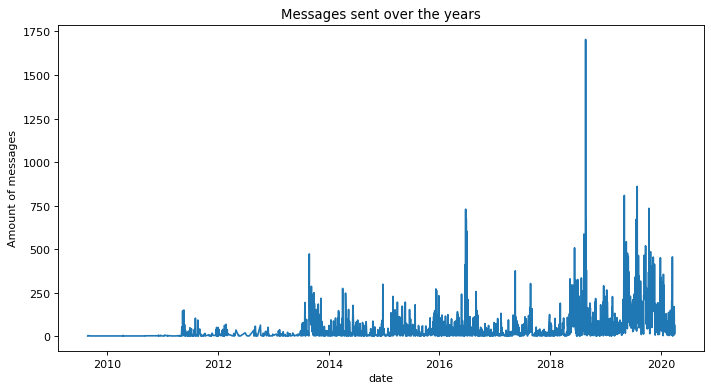

In [8]:
fig=plt.figure(figsize=(9, 5), dpi= 80, facecolor='w', edgecolor='k')

ax = sns.lineplot(x="date", y="content", data=year)
plt.title("Messages sent over the years")
plt.ylabel("Amount of messages")

plt.tight_layout()

#### Other non text indicators

In [9]:
cols = ['reactions','photos','sticker','conv_name',
        'call_duration','files','videos','audio_files']
tmp = {'reactions' : "count", 'photos' : "count",
      "sticker" : "count", 'call_duration' : 'sum',
      'files' : "count", 'videos' : 'count','audio_files' : 'count'}
indicators = overall_data[cols].agg(tmp).reset_index()
for elt in np.array(indicators):
    if elt[0] == 'call_duration':
        print(str(round(elt[1]/(1000*60))) + " minutes of call shared.")
    else:
        print(str(round(elt[1])) +" "+ str(elt[0]) + " " +"shared." )

2983 reactions shared.
2079 photos shared.
427 sticker shared.
40 minutes of call shared.
207 files shared.
62 videos shared.
65 audio_files shared.


## Individual view and wordclouds

### Data preparation for the wordclouds

To create my wordclouds I use a TF IDF method. In order to reduce the dimensionnality of the text I :
- Lowercase my conversations
- Remove some french stopwords
- Do some regex cleaning
- Lemmatize the conversation (https://en.wikipedia.org/wiki/Lemmatisation)

For the lemmatisation I use the package treetagger wrapper adapted to Python. You can download it following following this procedure : https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/ and then pip install the tree tagger wrapper python package.

####  Autocorrect : 
I hesitated to use "simple" autocorrects (based on Levenstein distance for example) but i felt like it would delete some ways of speaking of me or my friends so  i let the conversations with the potential typos.

In [10]:
import json
import ftfy
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
from nltk.corpus import stopwords
import json
import numpy as np
import string
import treetaggerwrapper
import pickle
import time 


path = os.getcwd() + '\conversations'
convs = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
conv_data = pd.DataFrame(columns = ['Name','Conv'])

#Initializes the tagger (change the TAGDIR argument by your treetagger wrapper instalation folder)
tagger = treetaggerwrapper.TreeTagger(TAGLANG='fr',
                                      TAGDIR = 'C:/Users/x/Desktop/f/tree-tagger-windows-3.2.1/TreeTagger')

#Gets the stopword list for french texts
stop = stopwords.words('french')



def Lemm(x,tagger):
    """Take a french string an returns it lemmatized form"""
    lst=['DET:POS',"DET:ART","PRP","PRO:DEM","KON","PUN","PRO:PER","SENT"]
    
    #Ensure that our string is not empty
    if x == "" or x == " ":
        return([])
    else:
        #Ensure that treetagger returns an array
        try:
            tag = np.array(treetaggerwrapper.make_tags(tagger.tag_text(x)))
        except:
            return(np.nan)
        #Ensure that the array is in the good shape
        try: 
            tag = tag[np.isin(tag[:,1],lst,invert = True)]
            return(tag[:,2])
        except:
            return(np.nan)

# Get the emoji patterns
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def del_emoji(s):
    """Takes a string and delete its emojis"""
    return(emoji_pattern.sub(r'', s))


C:\ProgramData\Anaconda3\lib\site-packages\treetaggerwrapper.py:740: FutureWarning: Possible nested set at position 8
  re.IGNORECASE | re.VERBOSE)
C:\ProgramData\Anaconda3\lib\site-packages\treetaggerwrapper.py:2044: FutureWarning: Possible nested set at position 152
  re.VERBOSE | re.IGNORECASE)
C:\ProgramData\Anaconda3\lib\site-packages\treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
C:\ProgramData\Anaconda3\lib\site-packages\treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


In [11]:
s = time.time()
i = 1
for file in convs:
    with open(os.path.join(path, file)) as f:
        data = json.load(f)
    a = data["messages"]
    
    for elt in a:
        for key in elt.keys():
            if type(elt[key]) == str:
                #Removes https\link
                elt[key] = re.sub(r'^https?:\/\/.*[\r\n]*', '', elt[key], flags=re.MULTILINE)
                #Removes http\link
                elt[key] = re.sub(r'http\S+', '', elt[key], flags=re.MULTILINE)
                #Removes www.link
                elt[key] = re.sub(r'www.\S+', '', elt[key], flags=re.MULTILINE)
                #Removes word@word
                elt[key] = re.sub(r'\S+@\S+', '', elt[key], flags=re.MULTILINE)
                #Removes link.com
                elt[key] = re.sub(r'\S+\.com', '', elt[key], flags=re.MULTILINE)
                elt[key] = re.sub(r'[ ,.]', ' ', elt[key], flags=re.MULTILINE)
                #Removes entire digits
                elt[key] = re.sub(r'\b\d+\b', '', elt[key], flags=re.MULTILINE)
                #elt[key] = re.sub(r'[^\w\s]','',elt[key])
                elt[key] = str(ftfy.fix_text(elt[key])).lower()
                elt[key] = " ".join([word for word in elt[key].split() if word not in stop])
                #elt[key] = elt[key].translate(str.maketrans('','',string.punctuation))
                #Removes the thing like 'user has sended a gif' (in french ofc)
                elt[key] = re.sub(r'.*a envoyé+\s(gif|pièce|message|photo|vidéo|sticker).*', ' ',elt[key], flags=re.MULTILINE)
                #Removes smileys (like : :) :/ ;$$ x) )
                elt[key] = re.sub(r'(:|;|x)(\)|\(|\$|/|3|o|\@|\'|s|p)+',' ',elt[key],flags = re.MULTILINE)
                #Removes pronoun before apostropheses (ça s'arrange --> ça arrange)
                elt[key] = re.sub(r'\S+\'',' ',elt[key],flags = re.MULTILINE)
                #Removes /\!?$.=
                elt[key] = re.sub(r'(\:|\/|\\|\?|\§|\!|\.|\<|\>|\(|\)|\=)',' ',elt[key],flags = re.MULTILINE)
                #Replace multiple spaces by one space
                elt[key] = re.sub(r'\s\s+',' ',elt[key],flags = re.MULTILINE)
                #Replaces hahahahaha by haha or hehehe by hehe 
                elt[key] = re.sub(r'[ah|ha]{3,}','haha',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r'[éh|hé]{3,}','hehe',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r'[eh|he]{3,}','eheh',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r' [ih|hi]{3,}','hihi',elt[key],flags = re.MULTILINE)
                #Deletes emoji
                elt[key] = del_emoji(elt[key])
                
                #Deletes game scores
                if "a record" in elt[key]:
                    elt[key] = ""
                #Normalize the data
                elt[key] = unicodedata.normalize('NFKD', elt[key]).encode('ascii','ignore').decode("utf-8")

    #Store in a temporary dataframe
    df = pd.DataFrame(a)
    #Dropna
    df = df.dropna(subset = ['content'])
    #Removes call
    df = df[df['type'] != "call"]
    # The messages are ordered to the last one from the first first one, we invert it
    df = df.reindex(index=df.index[::-1])
    # We create a Lemmatized text column
    df['Lemm'] = df.content.apply(Lemm,args = (tagger,))
    # DropNas in the lemmatized column
    df = df.dropna(axis=0,subset=['Lemm'])
    # Transforms the column into a log text (splitted in list)
    conv = " ".join([element for list_ in df['Lemm'] for element in list_])
    tmp = {"Name" : file.replace('.json',''),"Conv" : conv}
    tmp = pd.DataFrame(tmp,index=[0])
    conv_data = pd.concat([conv_data,tmp],axis = 0,ignore_index=True)
    if i % 10 == 0:
        e = time.time()
        print(str(i) + " files treated. Time elapsed : " + str(round(e - s)) + " sec.")
    i +=1
e = time.time()
print('Finished in ' + str(round(e - s)) + " sec.")

10 files treated. Time elapsed : 87 sec.
20 files treated. Time elapsed : 109 sec.
30 files treated. Time elapsed : 143 sec.
40 files treated. Time elapsed : 175 sec.
Finished in 190 sec.


In [12]:
#Dataframe head
conv_data.sample(frac=1).iloc[:2]

,Name,Conv
45,SC,bonjour loic ca aller salut samantha ca aller ...
16,GF,salut loic reunion investissement boursier pro...


#### Wordcloud (tf-idf) based

To select the words which are meaning in each conversation I use a tf idf (term frequency-inverse document frequency)  technic. The wordcloud choose the words with the highest tf idf score of the conversation.

To be short : a word in a conversation is important if this has a strong occurence in the conversation but also if it does not occurs a lot in the other conversations treated. The TF-IDF score for a word in a conversation will increase with those two criteria. You can find more informations (and the maths behind it) here: https://fr.wikipedia.org/wiki/TF-IDF.

In [13]:
import pandas as pd
import numpy as np 
import pickle
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer,CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

#Choose the conversation name you want to analyze
Name = "PB"
#Choose the number of topwords
topwords = 100
docs = conv_data['Conv']
doc2 = conv_data[conv_data.Name == Name]['Conv']
# Counts the number of unique words 
all_doc = " ".join(list(docs))
all_doc = all_doc.split(' ')
total_voca = np.unique(all_doc)
doc2 = " ".join(list(doc2)).split(' ')
total_voca_conv = np.unique(doc2)
print("Unique words in all the conversations : " + str(total_voca.shape[0]))
print("Unique words in the " + Name +  " conversation : " + str(total_voca_conv.shape[0]))


Unique words in all the conversations : 28600
Unique words in the PB conversation : 1165


#### Transform the conversations into a TF IDF matrix

In [14]:
#Vectorization en matrice de tf idf 
#Counteur 
cv=CountVectorizer(max_df=0.5)#Prend les 72% des mots les plus occurents
word_count_vector=cv.fit_transform(docs)
feature_names=cv.get_feature_names()

#TfIdfVectorizer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

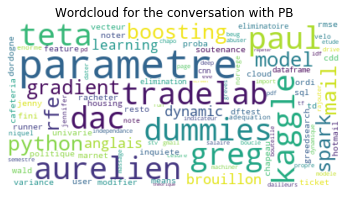

In [15]:
# Extraction des mots les plus importants
def sort_coo(coo_matrix):
    """Prend les deux listes (index de voca et tf-idf) et la trie par ordre croissant"""
    tuples = zip(coo_matrix.col, coo_matrix.data) #Join index et valeur
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True) #Trie les valeurs

tf_idf_vector=tfidf_transformer.transform(
        cv.transform(list(conv_data[conv_data.Name == Name]['Conv'])))

#sort the tf-idf vectors by descending order of scores
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """Sort le top n des tf idf à partir d'une table triée"""
    
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    

    for idx, score in sorted_items:
        
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

sorted_items=sort_coo(tf_idf_vector.tocoo())
keywords=extract_topn_from_vector(feature_names,sorted_items,topwords)
text = " ".join(keywords.keys())


# Genarates the word cloud

wordcloud = WordCloud(max_font_size=50, max_words=topwords, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud for the conversation with " + Name)
plt.show()


This is the wordcloud of the conversation with a college friend. We mainly talk about common friends, machine learning and courses. The words outputed by this WordCloud represents well this conversation IMO.

### Conversation clustering 

In this part I look to create a vector representation of my conversation in order to do some clustering on it.

#### Conversation "embedding" : Doc2Vec or TF IDF vectors ?

Doc2vec is a technic of text embedding which can be seen as an extension of word2vec. The idea is to add to the CBOW version of word2vec an hot encoded vector which represents the document id. During the learning phase the algorithm learns an embeded form of the document. It exists also another version which consists in predicting sampled words of the document with only the document id.


In an other hand we can just take the tf-idf vectors of each documents to embed them.

The problem with doc2vec  is that it needs a lot of documents to create robust embeddings. Here I have only 40 conversations to input to the algorithm and, to have tested doc2vec with several hyper parameters, it fails to learn similarities with my conversations (they had no sense for me). So I decided to keep the tf idf vector form of my documents for the clustering.

####  Clustering technic  : 

For the clustyering I deciced to use a hierachichal ascending clustering technic. I use a ward method to choose the cluster/datapoints distance. I use a simple euclidean distance between the vectors, honestly I did not try any other ones because the result was pretty satisfying for my conversations. After some tries I choosed to truncate the results when the distance was superior to 1.5. It can vary according to the distance measure, the method of linkage, and the data you treat. Feel free to change the parameters. 

In [16]:
def fancy_dendrogram(linkage,*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = shc.dendrogram(linkage,*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Conversations Dendogram')
        plt.xlabel('Conversation (anonymized) names')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                            textcoords='offset points',
                            va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

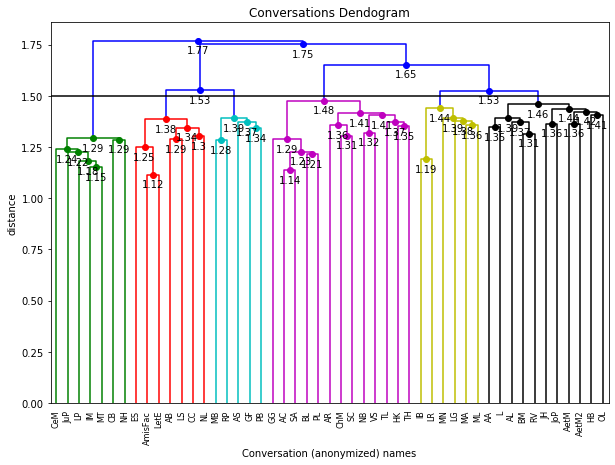

In [17]:
######## Clustering
import scipy.cluster.hierarchy as shc
from scipy.cluster import hierarchy
import matplotlib as mpl

data =  pd.DataFrame(tfidf_transformer.transform(
        cv.transform(list(conv_data['Conv']))).toarray(),index = conv_data['Name'])
plt.figure(figsize=(10, 7))

linkage = shc.linkage(data, method='ward')

fancy_dendrogram(
    linkage,
    labels=conv_data['Name'].tolist() ,
    max_d=1.5  # plot a horizontal cut-off line
)
plt.show()



This dendogram represents pretty well my affinities for my different conversations. For example the green group represent my college friends that I'm really close to, the red one the college friends that I'm less close to, the azur one are my friends from another place that I live etc.

#### Dimension reduction : PCA or TSNE ?

PCA is a dimension technic which has for objective to create recursivly axis which preserves the most of the total variance of the data. 

TSNE is another dimension reduction technic (often used for text data) which have for objective to create low dimensionnal space which respects the probability distribution of the original large dimensionnal space. TSNE algorithm wil try to respects the distances of each points from the original space to the reduced one.
(To really learn about it : 
- https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
- https://www.youtube.com/watch?v=NEaUSP4YerM)


After some tries (and some hyperparemeters tuning) TSNE failed to give me a good representation of my conversations. PCA was much "accurate" even if the two first axis does not explain a lot of the total variance. So I fitted my data on the PCA algorithm 

In [18]:
from sklearn.cluster import AgglomerativeClustering
ac2 = AgglomerativeClustering(n_clusters = 7) 

c = ac2.fit_predict(data) 


Text(0.5, 1, 'Conversation representation')

<Figure size 1152x720 with 0 Axes>

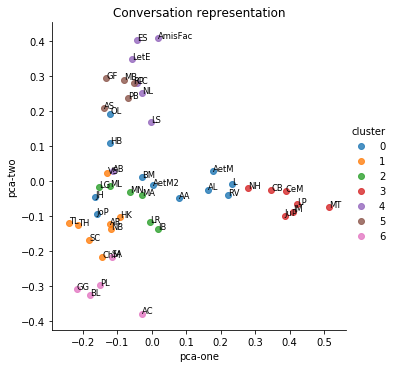

In [19]:
#from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000)
#tsne_results = tsne.fit_transform(data)
pca = PCA(n_components=10)
pca_result = pca.fit_transform(data)


data['pca-one'] = pca_result[:,0]
data['pca-two'] = pca_result[:,1] 

data['cluster'] = c

#data['tsne-2d-one'] = tsne_results[:,0]
#data['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
# basic plot
p1=sns.lmplot(data=data, x='pca-one', y='pca-two', fit_reg=False,hue = 'cluster')
ax = p1.axes[0,0] 
# add annotations one by one with a loop
for line in range(0,data.shape[0]):
     ax.text(data['pca-one'][line], data['pca-two'][line], data.index[line], horizontalalignment='left', size='small', color='black')

plt.title("Conversation representation")


### Word embeding using word2vec

In this section I use word2vec to create a unique conversation embedding. Word2vec is word embedding algorithm. It is basically a small neural network trying  to predict a target word of a sentence from some contexts surrounding words  (CBOW version) or to predict some contexts words  based on a single word in the sentence. If you are not familiar to it, this video explains very well the algorithm and the mathematics behind ().

I tried W2V algorithm with different hyparemeters but I was not able to get good results for my conversations (ie it failed the analogies that was meaningfull to me like  friends closeness). However you can find the code here and try to fine tune it for yours. If it works it could be interesting to do some dataviz on it.

#### Package import 


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import time
import pickle
import multiprocessing
from gensim.models import Word2Vec

#### Data preparation

For word embedding, it seemed important to have the message level of my conversations and not only a big list of conversations. Thus I re extract my conversations json to create an appropriate dataframe. This time I : 
- Remove some regex (not exactly the as before)
- Do not remove stopwords (skipgram model handles pretty well frequent words)
- Do not lemmatize it
- Remove punctuation and some special characters
- Concatenate the messages which are from the same sender without any other senders between and which close in timestamp (to transforms things like : ["Hey", "have you read this book ?" ] to ["Hey have you read this book ?" ] )


In [21]:




def concat_message(df):
    """Concat the messages which are from the same sender without any other senders between and which close in timestamp"""
    i = 0
    data = pd.DataFrame(columns = ["sender_name","timestamp_ms","content"])
    while i < df.index.shape[0]:
        sender = df['sender_name'][i]
        msg =  df["content"].loc[i]
        tt = df["timestamp_ms"].loc[i]
        tmp = True
        j = 1

        while tmp:
            if i + j <df.index.shape[0]:
                if df['sender_name'].loc[i+j] == sender:
                    if df["timestamp_ms"].loc[i+j] < 5 * 60 * 1000 + tt:
                        msg += " " +  df["content"].loc[i + j]
                        tt = df["timestamp_ms"].loc[i+j]
                        j += 1
                    else:
                        tmp = False
                else:
                    tmp = False
            else:
                tmp = False
        i +=j
        dic = {"sender_name":[sender],"timestamp_ms" : [tt],"content": [msg]}
        dic = pd.DataFrame(dic)
        data = pd.concat([data,dic],axis = 0,ignore_index=True)
    return(data)

def repl(m):
    """Transforms a string to space + string + space"""
    return " {} ".format(m.group())            
                

In [22]:
s = time.time()
i = 1

w2v_data = pd.DataFrame(columns = ["sender_name","timestamp_ms","content"])
for file in convs:
    with open(os.path.join(path, file)) as f:
        data = json.load(f)
    a = data["messages"]
    
    for elt in a:   
        for key in elt.keys():
            
            if key == 'content':
                #Removes https\link
                elt[key] = re.sub(r'^https?:\/\/.*[\r\n]*', '', elt[key], flags=re.MULTILINE)
                #Removes http\link
                elt[key] = re.sub(r'http\S+', '', elt[key], flags=re.MULTILINE)
                #Removes www.link
                elt[key] = re.sub(r'www.\S+', '', elt[key], flags=re.MULTILINE)
                #Removes word@word
                elt[key] = re.sub(r'\S+@\S+', '', elt[key], flags=re.MULTILINE)
                #Removes link.com
                elt[key] = re.sub(r'\S+\.com', '', elt[key], flags=re.MULTILINE)
                elt[key] = re.sub(r'[ ,.]', ' ', elt[key], flags=re.MULTILINE)
                #Removes entire digits
                elt[key] = re.sub(r'\b\d+\b', '', elt[key], flags=re.MULTILINE)
                elt[key] = str(ftfy.fix_text(elt[key])).lower()
                
                #Removes smileys (like : :) :/ ;$$)
                elt[key] = re.sub(r'(:|;)(\)|\(|\$|/|3|\@|\'|s|p)+',' ',elt[key],flags = re.MULTILINE)
                #Removes  apostropheses (ça s'arrange --> ça s arrange)
                elt[key] = re.sub(r'\'',' ',elt[key],flags = re.MULTILINE)
                #Removes /\$()=
                elt[key] = re.sub(r'(\/|\\|\§|\(|\)|\=)',' ',elt[key],flags = re.MULTILINE)
                
                #Replaces hahahahaha by haha or hehehe by hehe 
                elt[key] = re.sub(r'[ah|ha]{3,}','haha',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r'[éh|hé]{3,}','hehe',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r'[eh|he]{3,}','eheh',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r' [ih|hi]{3,}','hihi',elt[key],flags = re.MULTILINE)
                #Replace punctuation by the same character + spaces
                pattern = re.compile(r'(\.|\?|\!)')
                elt[key] = re.sub(pattern, repl, elt[key])
                #Replace multiple spaces by one space
                elt[key] = re.sub(r'\s\s+',' ',elt[key],flags = re.MULTILINE)
                elt[key] = del_emoji(elt[key])
                #DELETES EMOJI
                elt[key] = del_emoji(elt[key])

                #Deletes game scores
                if "a record" in elt[key]:
                    elt[key] = ""
                #Normalize the data
                elt[key] = unicodedata.normalize('NFKD', elt[key]).encode('ascii','ignore').decode("utf-8")

    #Store in a temporary dataframe
    df = pd.DataFrame(a)
    #Dropna
    df = df.dropna(subset = ['content'])
    #Removes calls, photos, stickers,gif,files,videos,audio files 
    df = df[df['type'] == "Generic"]
    
    # The messages are ordered to the last one from the first first one, we invert it
    df = df.reindex(index=df.index[::-1]).reset_index()
    
    df = df[["sender_name","timestamp_ms","content"]]
    #Concatenates the messages
    df =concat_message(df)
    w2v_data = pd.concat([w2v_data,df],axis = 0,ignore_index=True)
    if i % 10 == 0:
        e = time.time()
        print(str(i) + " files treated. Time elapsed : " + str(round(e - s)) + " sec.")
    i +=1
w2v_data.content = w2v_data.content.astype(str).apply(lambda x: x.split())

e = time.time()
print('Finished in ' + str(round(e - s)) + " sec.")

10 files treated. Time elapsed : 117 sec.
20 files treated. Time elapsed : 139 sec.
30 files treated. Time elapsed : 164 sec.
40 files treated. Time elapsed : 196 sec.
Finished in 213 sec.


In [23]:
w2vdata = w2v_data.content
 

In [24]:

#Initialize W2V model

EMBEDDING_DIM = 300
w2v_model = Word2Vec(min_count=10,#if the occurence is < to this threshold then ignore
                     window=2,#window of words to predict (skipgram case)
                     size=EMBEDDING_DIM,#dim of the embeded vector
                     sample=1e-5, #threshold at which we under sample the words
                     alpha=0.05, #learning rate
                     min_alpha=0.0007, # min learning rate which we will cap
                     negative=30,# nb of subsample in the negative words (neg sub sampling)
                     workers=-1,
                     sg = 1#Skipgram model
                     )
t = time.time()


#Initialize vocab
w2v_model.build_vocab(w2vdata, progress_per=10000)


#Train the model
t = time.time()

w2v_model.train(w2vdata, total_examples=w2v_model.corpus_count, epochs=20, report_delay=1)


w2v_model.init_sims(replace=True)



In [108]:
w2v_model.most_similar(positive = ["statistiques"])[:4]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('tlse', 0.1976611614227295),
 ('parfois', 0.18022608757019043),
 ('deco', 0.17332279682159424),
 ('concours', 0.1705390214920044)]

As I told, I did not go any further on it because the embedding failed to outputs the analogies I wanted to see.

### Text generation

In this part I use my message to create a text generator which should write like I do (thanks to my message data). To do so I use an RNN with LSTM cells. It basically creates a language model based on my sentences. Most of the implementation code comes from this Notebook that i modified a bit: https://www.kaggle.com/tannergi/text-generation-using-an-lstm-in-keras.

I am currently training this implementation on google colab (because of the gpus). I'll further complete this last part.

TODO : Improve the impementation (sos and eos tokens, try different architectures ...)

####  Word level or character level model ?

I have written/modified code for the two versions but I think character level can lead to better results in this special case for two reasons. The first one is that even if a word level language level is more accurate most of the time, it is more costly to train and needs more data. The second one is that there is a lot of typos in my conversations that I can't correct with an auto correct without deleting some of my ways of speaking.
 

#### Package import

In [26]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation,Embedding
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

#### Data preparation :
The data pre processing looks a lot like the one in the W2V part. However I did not delete the same regex and did not remove the punctuation.

In [27]:
import re
import ftfy
s = time.time()
i = 1
def repl(string):
    """Function to add space beween a specific pattern"""
    return " {} ".format(string.group())
import unicodedata


chat_data = pd.DataFrame(columns = ["sender_name","timestamp_ms","content"])
for file in convs:
    with open(os.path.join(path, file)) as f:
        data = json.load(f)
    a = data["messages"]
    
    for elt in a:   
        for key in elt.keys():
            
            if key == 'content':
                elt[key] = re.sub(r'\\U000f[A-Za-z0-9]+',' ',elt[key],flags = re.MULTILINE)

                #Removes https\link
                elt[key] = re.sub(r'^https?:\/\/.*[\r\n]*', '', elt[key], flags=re.MULTILINE)
                #Removes http\link
                elt[key] = re.sub(r'http\S+', '', elt[key], flags=re.MULTILINE)
                #Removes www.link
                elt[key] = re.sub(r'www.\S+', '', elt[key], flags=re.MULTILINE)
                #Removes word@word
                elt[key] = re.sub(r'\S+@\S+', '', elt[key], flags=re.MULTILINE)
                #Removes link.com
                elt[key] = re.sub(r'\S+\.com', '', elt[key], flags=re.MULTILINE)
                elt[key] = re.sub(r'[ ,.]', ' ', elt[key], flags=re.MULTILINE)
                elt[key] = str(ftfy.fix_text(elt[key])).lower()
                
                #Removes smileys (like : :) :/ ;$$)
                elt[key] = re.sub(r'(:|;)(\)|\(|\$|/|3|\@|\'|s|p|o)+',' ',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r'(x)(\)|\(|\$)+',' ',elt[key],flags = re.MULTILINE)
                #Removes  apostropheses (ça s'arrange --> ça s arrange)
                elt[key] = re.sub(r'\'',' ',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r'\\n',' ',elt[key],flags = re.MULTILINE)
                #Replaces hmmmmm by hmm
                elt[key] = re.sub(r'(h)[m]{2,}','hmm',elt[key],flags = re.MULTILINE)
                #Replaces 
                
            
                #Replaces hahahahaha by haha or hehehe by hehe 
                elt[key] = re.sub(r'[ah|ha]{3,}','haha',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r'[éh|hé]{3,}','hehe',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r'[eh|he]{3,}','eheh',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r' [ih|hi]{3,}','hihi',elt[key],flags = re.MULTILINE)
                #Deletes []{}\n\t;
                elt[key] = re.sub(r'(\[|\]|\{|\}|\\n|\\t|\@|\\|\#|\=|\<|\>|\_)',' ',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub("\n",' ',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub("\t",' ',elt[key],flags = re.MULTILINE)
                elt[key] = re.sub(r'(\^|\*|\_|\/)','',elt[key],flags = re.MULTILINE)
                
                #Replace punctuation by the same character + spaces
                pattern = re.compile(r'(\.|\?|\!|\(|\))')
                elt[key] = re.sub(pattern, repl, elt[key])
                #DELETES EMOJI
                #elt[key] = del_emoji(elt[key])

                #Normalize the data
                elt[key] = unicodedata.normalize('NFKD', elt[key]).encode('ascii','ignore').decode("utf-8")
                #Replace multiple spaces by one space
                elt[key] = re.sub(r'\s\s+',' ',elt[key],flags = re.MULTILINE)
                elt[key] = elt[key].rstrip().lstrip()
                

    #Store in a temporary dataframe
    df = pd.DataFrame(a)
    #Dropna
    df = df.dropna(subset = ['content'])
    #Removes calls, photos, stickers,gif,files,videos,audio files 
    df = df[df['type'] == "Generic"]
    
    # The messages are ordered to the last one from the first first one, we invert it
    df = df.reindex(index=df.index[::-1]).reset_index()
    
    df = df[["sender_name","timestamp_ms","content"]]
    #Concatenates the messages
    df =concat_message(df)

    chat_data = pd.concat([chat_data,df],axis = 0,ignore_index=True)
    if i % 10 == 0:
        e = time.time()
        print(str(i) + " files treated. Time elapsed : " + str(round(e - s)) + " sec.")
    i +=1
#chat_data.content = chat_data.content.astype(str).apply(lambda x: x.split())
chat_data['sender_name'] = chat_data['sender_name'].astype(str).apply(fix_text)

e = time.time()
print('Finished in ' + str(round(e - s)) + " sec.")

10 files treated. Time elapsed : 116 sec.
20 files treated. Time elapsed : 138 sec.
30 files treated. Time elapsed : 163 sec.
40 files treated. Time elapsed : 195 sec.
Finished in 216 sec.


#### Character level data

In [28]:
from keras.preprocessing.text import Tokenizer

maxlen = 60
#Keeping only my messages
chat_data = chat_data[chat_data.sender_name == "Loïc"]
#Create a lenght of sentence column
chat_data['length'] = chat_data["content"].astype(str).apply(lambda x: len([c for c in x]))
#Deleting all the messages makes less than 4 chars
chat_data = chat_data[chat_data.length > 4]
#Creates the text as list of words
chat_data["seq"] = chat_data["content"].astype(str).apply(lambda x: [c for c in x])

tokenizer_chars = Tokenizer(filters='',char_level=True)
#Transforms the text as a vocab index
tokenizer_chars.fit_on_texts(chat_data["content"])
vocab_size = len(tokenizer_chars.word_counts)

chat_data["tokens"] = chat_data.content.apply(tokenizer_chars.texts_to_sequences)

In [29]:
data_chars = pd.DataFrame(columns = ['X','y'])

for i in chat_data.index:
    X = []
    y = []
    if len(chat_data["tokens"][i]) - maxlen <= 0:
        X.append(np.array(chat_data["tokens"][i][:-1]).ravel())
        y.append(chat_data["tokens"][i][-1])

    for j in range(len(chat_data["tokens"][i]) - maxlen):
        X.append(np.array(chat_data["tokens"][i][j:j + maxlen]).ravel())
        y.append(chat_data["tokens"][i][j + maxlen])
    tmp = {'X':X,'y':y}
    tmp = pd.DataFrame(tmp)
    data_chars = pd.concat([data_chars,tmp])

In [30]:
pickle.dump(data_chars,open('text_gen_data_chars.p','wb'))
pickle.dump(tokenizer_chars,open('text_gen_token_chars.p','wb'))


#### Word level data

In [31]:
from keras.preprocessing.text import Tokenizer

maxlen = 10
#Keeping only my messages
chat_data = chat_data[chat_data.sender_name == "Loïc"]
#Create a lenght of sentence column
chat_data['length'] = chat_data["content"].astype(str).apply(lambda x: len(x.split(" ")))
#Deleting all the messages makes less than 2 words
chat_data = chat_data[chat_data.length > 1]
#Creates the text as list of words
chat_data["seq"] = chat_data["content"].astype(str).apply(lambda x: x.split(" "))

tokenizer_words = Tokenizer(filters='',char_level = False,oov_token="oov")
#Transforms the text as a vocab index
tokenizer_words.fit_on_texts(chat_data["content"])
vocab_size = len(tokenizer_words.word_counts)

chat_data["tokens"] = tokenizer_words.texts_to_sequences(chat_data["content"])

In [32]:
data_words = pd.DataFrame(columns = ['X','y'])

for i in chat_data.index:
    X = []
    y = []
    if len(chat_data["tokens"][i]) - maxlen <= 0:
        try:
            y.append(chat_data["tokens"][i][-1])
            X.append(np.array(chat_data["tokens"][i][:-1]).ravel())
        except:
            pass

    for j in range(len(chat_data["tokens"][i]) - maxlen):
        try:
            y.append(chat_data["tokens"][i][j + maxlen])
            X.append(np.array(chat_data["tokens"][i][j:j + maxlen]).ravel())
        except:
            pass
        
    tmp = {'X':X,'y':y}
    tmp = pd.DataFrame(tmp)
    data_words = pd.concat([data_words,tmp])

In [33]:
pickle.dump(data_words,open('text_gen_data_words.p','wb'))
pickle.dump(tokenizer_words,open('text_gen_token_words.p','wb'))


#### Word level language model

In [92]:
import pickle
import pandas as pd
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation,Embedding
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
from keras.preprocessing.text import Tokenizer
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences


data = pickle.load(open("text_gen_data_words.p","rb"))
tokenizer = pickle.load(open("text_gen_token_words.p","rb"))

indices_char = tokenizer.index_word
char_indices = dict([(value,key) for key,value in tokenizer.index_word.items()])
maxlen = 10
vocab_size = len(indices_char)

In [93]:
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(data['X'], maxlen=maxlen, padding='pre')
#y = pad_sequences(data['y'], maxlen=1, padding='post')
#X = to_categorical(X)
y = to_categorical(data['y'],num_classes=vocab_size+1)

In [94]:
def create_model(vocab_size, seq_len):

    model = Sequential()
    #Embedding layer
    model.add(Embedding(vocab_size+1, 8, input_length=seq_len))
    #Two reccurents lstm layers
    model.add(LSTM(units=2**6, return_sequences=True))

    model.add(LSTM(units=2**7))

    #Denese layers to break some linearities
    model.add(Dense(units=2**7, activation='relu'))

    #Softmax overall the letters
    model.add(Dense(units=vocab_size+1, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

    model.summary()

    return model
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

from keras.callbacks import LambdaCallback

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    choice = np.random.randint(0,X.shape[0])
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = X[choice]
        sentence= tokenizer.sequences_to_texts(X[choice:choice+1])[0]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(10):
            x_pred = np.array(tokenizer.texts_to_sequences(sentence.split(" "))).ravel()
            preds = model.predict(np.array([x_pred]), verbose=0)[0]
            next_index = sample(preds, diversity)
            next_word = tokenizer.sequences_to_texts(np.array([next_index]).reshape(1,1))[0]

            generated +=" " + next_word
            sentence =  " ".join(sentence.split(" ")[1:]) + " "  + next_word

            sys.stdout.write(" " + next_word)
            sys.stdout.flush()
    print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

def generate_text(sentence,length, diversity):
    """Generates thanks to a starting sentence the next words"""
    tmp = sentence
    generated = ''
    for i in range(length):
        x_pred = pad_sequences([np.array(tokenizer.texts_to_sequences(sentence.split(" "))).ravel()],
                          maxlen =maxlen)[0]
        preds = model.predict(np.array([x_pred]), verbose=0)[0]
        next_index = sample(preds, diversity)
        next_word = tokenizer.sequences_to_texts(np.array([next_index]).reshape(1,1))[0]

        generated +=" " + next_word
        sentence =  " ".join(tokenizer.sequences_to_texts([x_pred])[0].split(" ")[1:]) + " "  + next_word
    return tmp + " " + generated

In [95]:
from keras.callbacks import ModelCheckpoint

filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             verbose=1, save_best_only=True,
                             mode='min')

from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)
callbacks = [print_callback, checkpoint, reduce_lr]
model =create_model(vocab_size,maxlen)
#model.fit(X, y, batch_size=3000, epochs=100, callbacks=callbacks)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 10, 8)             182080    
_________________________________________________________________
lstm_21 (LSTM)               (None, 10, 64)            18688     
_________________________________________________________________
lstm_22 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_22 (Dense)             (None, 22760)             2936040   
Total params: 3,252,136
Trainable params: 3,252,136
Non-trainable params: 0
_________________________________________________________________


#### Word level language model


In [96]:
import pickle
import pandas as pd
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation,Embedding
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
from keras.preprocessing.text import Tokenizer
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences


data = pickle.load(open("text_gen_data_chars.p","rb"))
tokenizer = pickle.load(open("text_gen_token_chars.p","rb"))

indices_char = tokenizer.index_word
char_indices = dict([(value,key) for key,value in tokenizer.index_word.items()])
maxlen = 60
vocab_size = len(indices_char)

In [97]:
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(data['X'], maxlen=maxlen, padding='pre')
y = pad_sequences(data['y'], maxlen=1, padding='post')
#X = to_categorical(X)
y = to_categorical(y,num_classes=vocab_size+1)

In [98]:
def create_model(vocab_size, seq_len):

    model = Sequential()
    #Embedding layer
    model.add(Embedding(vocab_size+1, 8, input_length=seq_len))
    #Two reccurents lstm layers
    model.add(LSTM(units=2**6, return_sequences=True))

    model.add(LSTM(units=2**7))

    #Dense layers to break some linearities
    model.add(Dense(units=2**7, activation='relu'))

    #Softmax overall the letters
    model.add(Dense(units=vocab_size+1, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

    model.summary()

    return model
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

from keras.callbacks import LambdaCallback

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    choice = np.random.randint(0,X.shape[0])
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = X[choice]
        sentence= ''.join([indices_char[i] for i in sentence if i in indices_char.keys() ])
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen))
            for t, char in enumerate(sentence):
                x_pred[0, t] = char_indices[char]

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            try:
                next_char = indices_char[next_index]
            except:
                next_char = ""

            generated += next_char
            sentence = sentence[1:] + next_char
            sys.stdout.write(next_char)
        sys.stdout.flush()
    print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [99]:
from keras.callbacks import ModelCheckpoint
model = create_model(vocab_size, maxlen)
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             verbose=1, save_best_only=True,
                             mode='min')

from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)
callbacks = [print_callback, checkpoint, reduce_lr]

#model.fit(X, y, batch_size=3000, epochs=1, callbacks=callbacks)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 60, 8)             416       
_________________________________________________________________
lstm_23 (LSTM)               (None, 60, 64)            18688     
_________________________________________________________________
lstm_24 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_24 (Dense)             (None, 52)                6708      
Total params: 141,140
Trainable params: 141,140
Non-trainable params: 0
_________________________________________________________________
